In [1]:
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
import sys
# setting path 
sys.path.append('../')
from NeuralNetworks.NNs import FCFF_3L
from PointSampling.Ball import data_gen_ball
from visualization.plots_disc import plot_2d_proj_disc
from visualization.disc_training import plot_2d_proj_w
from Hamiltonians.Eikonal_LxF import Eikonal_sq_LF_multiD 
from Training.training_finite_sum import train_finite_sum
from error_test.cube_error import FD_loss
from error_test.disc_error import error_ball

dim = 5

radii = [3., 0.]
domain = data_gen_ball(radii, dim)

#Right-hand-side of the PDE
def f(X): return 1

#Boundary condition
def g(X): return 0

delta_list = [.7, .5, .2, .1, .05]
alpha_list = [2., 2., 2., 2., 2.]
rounds = len(delta_list)
training_params = {
    'numerical_scheme': Eikonal_sq_LF_multiD,
    
    'f': f, 
    'g': g, 
    'c': None,
    
    'beta': 0., ## parameter for the +u_i term 
    
    'lambda': 1. #weight parameter for the boundary loss
}

# Test data
x_grid = torch.linspace(-max(radii), max(radii), int(21))
print('delta_test = ', x_grid[1]-x_grid[0] )
X = torch.meshgrid([x_grid]*dim)
data_square = torch.cat([X[i].unsqueeze(-1) for i in range(dim)], dim = -1).reshape([-1, dim])
test_data = data_square[data_square.norm(dim = -1) < max(radii)]
print('Number of test points =', test_data.shape[0])

n_experiments = 10

delta_test =  tensor(0.3000)
Number of test points = 526979


C:\Users\usuario\anaconda3\envs\FD_PINNs\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Fixed collocation points I

In [2]:
MSE_history1 = torch.zeros([n_experiments, rounds])
L_inf_error_history1 = torch.zeros([n_experiments, rounds]) 

training_error_history1 = torch.zeros([n_experiments, rounds])
test_error_history1 = torch.zeros([n_experiments, rounds])

training_error_history1_max = torch.zeros([n_experiments, rounds])
test_error_history1_max = torch.zeros([n_experiments, rounds])


for j in range(n_experiments):
    # We initialise the NN
    NN1 = FCFF_3L([dim,30,30])
    training_params['optimizer'] = optim.SGD(NN1.parameters(), lr = .01, momentum = .2)
    
    ## Here we sample the collocation points and the boundary points.
    training_data_int = domain.rand_int_points(0., 200)
    training_data_bound = domain.rand_bound_points(40)
    
    training_params['epochs'] = 500
    training_params['batch_size'] = 50

    
    for i in range(rounds):
    
        training_params['alpha'] = alpha_list[i]
        training_params['delta'] = delta_list[i]
        
        total_loss, PDE_loss, boundary_loss = train_finite_sum(NN1, training_data_int, 
                                                               training_data_bound, training_params)

        MC_points = int(1e5) # Number of grid points for comparison with the ground truth
        MSE, L_inf = error_ball(NN1, max(radii), MC_points, display = False)
        
        with torch.no_grad():
            training_error = FD_loss(NN1, training_data_int, training_params)
            test_error = FD_loss(NN1, test_data, training_params)
        
        training_error_history1[j,i] = training_error.mean()
        test_error_history1[j,i] = test_error.mean()
        training_error_history1_max[j,i] = training_error.max().item()
        test_error_history1_max[j,i] = test_error.max().item()
        
        MSE_history1[j,i] = MSE
        L_inf_error_history1[j,i] = L_inf
    
        #epochs =  training_params['epochs']
        #plt.plot(torch.arange(epochs)+1, total_loss)
        #plt.plot(torch.arange(epochs)+1, PDE_loss)
        #plt.plot(torch.arange(epochs)+1, boundary_loss)
        #plt.legend(labels=['Total loss', 'PDE loss', 'BC loss'])
        #plt.show()
        
        #X_axis = 0
        #Y_axis = 1
        #n_grid = 100
        
        #plot_2d_proj_disc(X_axis, Y_axis, NN1, n_grid, n_grid, radii)
        #plot_2d_proj_w(X_axis, Y_axis, NN1, n_grid, radii, training_params,training_data_int)
        
        print('Mean square error:', MSE)
        print('L-infinity error:', L_inf)

100%|██████████| 500/500 [00:08<00:00, 59.69it/s]


Mean square error: tensor(0.1819)
L-infinity error: tensor(2.0995)


100%|██████████| 500/500 [00:08<00:00, 60.94it/s]


Mean square error: tensor(0.1514)
L-infinity error: tensor(1.8937)


100%|██████████| 500/500 [00:08<00:00, 58.93it/s]


Mean square error: tensor(0.1111)
L-infinity error: tensor(1.4306)


100%|██████████| 500/500 [00:08<00:00, 62.36it/s]


Mean square error: tensor(0.1016)
L-infinity error: tensor(1.1485)


100%|██████████| 500/500 [00:08<00:00, 57.32it/s]


Mean square error: tensor(0.0722)
L-infinity error: tensor(0.9516)


100%|██████████| 500/500 [00:15<00:00, 31.54it/s]


Mean square error: tensor(0.1767)
L-infinity error: tensor(2.0809)


100%|██████████| 500/500 [00:18<00:00, 27.61it/s]


Mean square error: tensor(0.1431)
L-infinity error: tensor(1.8625)


100%|██████████| 500/500 [00:17<00:00, 27.91it/s]


Mean square error: tensor(0.1066)
L-infinity error: tensor(1.3802)


100%|██████████| 500/500 [00:17<00:00, 27.93it/s]


Mean square error: tensor(0.0867)
L-infinity error: tensor(1.1410)


100%|██████████| 500/500 [00:17<00:00, 27.91it/s]


Mean square error: tensor(0.0523)
L-infinity error: tensor(1.0285)


100%|██████████| 500/500 [00:17<00:00, 28.00it/s]


Mean square error: tensor(0.1605)
L-infinity error: tensor(2.0584)


100%|██████████| 500/500 [00:21<00:00, 22.90it/s]


Mean square error: tensor(0.1282)
L-infinity error: tensor(1.8420)


100%|██████████| 500/500 [00:22<00:00, 22.06it/s]


Mean square error: tensor(0.0893)
L-infinity error: tensor(1.3455)


100%|██████████| 500/500 [00:22<00:00, 22.18it/s]


Mean square error: tensor(0.0777)
L-infinity error: tensor(1.1008)


100%|██████████| 500/500 [00:23<00:00, 21.56it/s]


Mean square error: tensor(0.0411)
L-infinity error: tensor(0.8494)


100%|██████████| 500/500 [00:20<00:00, 24.32it/s]


Mean square error: tensor(0.1947)
L-infinity error: tensor(2.1120)


100%|██████████| 500/500 [00:20<00:00, 23.88it/s]


Mean square error: tensor(0.1616)
L-infinity error: tensor(1.9168)


100%|██████████| 500/500 [00:22<00:00, 22.15it/s]


Mean square error: tensor(0.1196)
L-infinity error: tensor(1.4114)


100%|██████████| 500/500 [00:19<00:00, 25.06it/s]


Mean square error: tensor(0.0818)
L-infinity error: tensor(0.9869)


100%|██████████| 500/500 [00:20<00:00, 24.97it/s]


Mean square error: tensor(0.0347)
L-infinity error: tensor(0.7268)


100%|██████████| 500/500 [00:18<00:00, 26.63it/s]


Mean square error: tensor(0.1477)
L-infinity error: tensor(2.0232)


100%|██████████| 500/500 [00:15<00:00, 31.52it/s]


Mean square error: tensor(0.1276)
L-infinity error: tensor(1.8266)


100%|██████████| 500/500 [00:08<00:00, 57.16it/s]


Mean square error: tensor(0.1071)
L-infinity error: tensor(1.4094)


100%|██████████| 500/500 [00:08<00:00, 59.63it/s]


Mean square error: tensor(0.1065)
L-infinity error: tensor(1.6884)


100%|██████████| 500/500 [00:08<00:00, 58.48it/s]


Mean square error: tensor(0.1150)
L-infinity error: tensor(1.8109)


100%|██████████| 500/500 [00:08<00:00, 60.48it/s]


Mean square error: tensor(0.1402)
L-infinity error: tensor(2.0303)


100%|██████████| 500/500 [00:08<00:00, 59.31it/s]


Mean square error: tensor(0.1051)
L-infinity error: tensor(1.8158)


100%|██████████| 500/500 [00:08<00:00, 56.30it/s]


Mean square error: tensor(0.0642)
L-infinity error: tensor(1.3226)


100%|██████████| 500/500 [00:08<00:00, 61.43it/s]


Mean square error: tensor(0.0562)
L-infinity error: tensor(1.0447)


100%|██████████| 500/500 [00:08<00:00, 59.96it/s]


Mean square error: tensor(0.0319)
L-infinity error: tensor(0.9189)


100%|██████████| 500/500 [00:08<00:00, 59.53it/s]


Mean square error: tensor(0.1949)
L-infinity error: tensor(2.1198)


100%|██████████| 500/500 [00:08<00:00, 58.56it/s]


Mean square error: tensor(0.1563)
L-infinity error: tensor(1.9200)


100%|██████████| 500/500 [00:08<00:00, 60.24it/s]


Mean square error: tensor(0.1135)
L-infinity error: tensor(1.4477)


100%|██████████| 500/500 [00:08<00:00, 57.00it/s]


Mean square error: tensor(0.1106)
L-infinity error: tensor(1.1778)


100%|██████████| 500/500 [00:08<00:00, 57.61it/s]


Mean square error: tensor(0.1207)
L-infinity error: tensor(1.1791)


100%|██████████| 500/500 [00:08<00:00, 57.15it/s]


Mean square error: tensor(0.1670)
L-infinity error: tensor(2.0863)


100%|██████████| 500/500 [00:08<00:00, 56.83it/s]


Mean square error: tensor(0.1365)
L-infinity error: tensor(1.8906)


100%|██████████| 500/500 [00:08<00:00, 60.94it/s]


Mean square error: tensor(0.0950)
L-infinity error: tensor(1.4075)


100%|██████████| 500/500 [00:08<00:00, 59.54it/s]


Mean square error: tensor(0.0767)
L-infinity error: tensor(1.1029)


100%|██████████| 500/500 [00:08<00:00, 60.94it/s]


Mean square error: tensor(0.0457)
L-infinity error: tensor(0.9481)


100%|██████████| 500/500 [00:09<00:00, 51.39it/s]


Mean square error: tensor(0.1652)
L-infinity error: tensor(2.0675)


100%|██████████| 500/500 [00:08<00:00, 59.32it/s]


Mean square error: tensor(0.1287)
L-infinity error: tensor(1.8493)


100%|██████████| 500/500 [00:08<00:00, 58.94it/s]


Mean square error: tensor(0.0858)
L-infinity error: tensor(1.3536)


100%|██████████| 500/500 [00:08<00:00, 58.37it/s]


Mean square error: tensor(0.0632)
L-infinity error: tensor(0.9822)


100%|██████████| 500/500 [00:08<00:00, 59.40it/s]


Mean square error: tensor(0.0536)
L-infinity error: tensor(0.8285)


100%|██████████| 500/500 [00:08<00:00, 58.61it/s]


Mean square error: tensor(0.1598)
L-infinity error: tensor(2.0608)


100%|██████████| 500/500 [00:08<00:00, 62.16it/s]


Mean square error: tensor(0.1250)
L-infinity error: tensor(1.8546)


100%|██████████| 500/500 [00:08<00:00, 59.84it/s]


Mean square error: tensor(0.0865)
L-infinity error: tensor(1.3715)


100%|██████████| 500/500 [00:08<00:00, 62.21it/s]


Mean square error: tensor(0.0661)
L-infinity error: tensor(1.0663)


100%|██████████| 500/500 [00:08<00:00, 62.42it/s]


Mean square error: tensor(0.0527)
L-infinity error: tensor(0.9099)


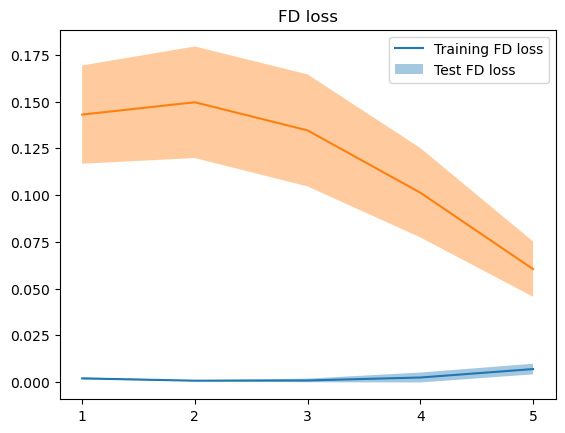

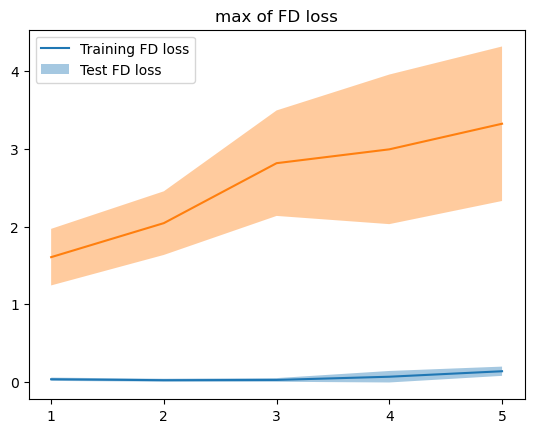

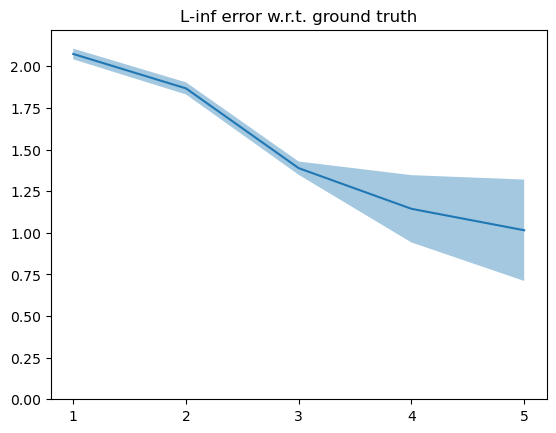

In [3]:
plt.plot(np.arange(rounds) , training_error_history1.mean(0))
plt.fill_between(np.arange(rounds) , 
                 training_error_history1.mean(0) - training_error_history1.std(0), 
                training_error_history1.mean(0) + training_error_history1.std(0), alpha=0.4)

plt.plot(np.arange(rounds) , test_error_history1.mean(0))
plt.fill_between(np.arange(rounds), 
                test_error_history1.mean(0) - test_error_history1.std(0),
                test_error_history1.mean(0) + test_error_history1.std(0), alpha = 0.4)

plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('FD loss')
plt.show()

plt.plot(np.arange(rounds) , training_error_history1_max.mean(0))
plt.fill_between(np.arange(rounds),
                 training_error_history1_max.mean(0) - training_error_history1_max.std(0),
                training_error_history1_max.mean(0) + training_error_history1_max.std(0),
                alpha = .4)

plt.plot(np.arange(rounds) , test_error_history1_max.mean(0))
plt.fill_between(np.arange(rounds),
                test_error_history1_max.mean(0) - test_error_history1_max.std(0),
                test_error_history1_max.mean(0) + test_error_history1_max.std(0),
                alpha = .4)
#plt.ylim(0, test_error_history1_max.max().item()+.1)
plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('max of FD loss')
plt.show()

plt.plot(np.arange(rounds), L_inf_error_history1.mean(0))
plt.fill_between(np.arange(rounds),
                L_inf_error_history1.mean(0) - L_inf_error_history1.std(0),
                L_inf_error_history1.mean(0) + L_inf_error_history1.std(0),
                alpha = .4)

plt.ylim(0, L_inf_error_history1.max().item()+0.1)
plt.title('L-inf error w.r.t. ground truth')
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.show()

# Fixed collocation points II


In [4]:
MSE_history2 = torch.zeros([n_experiments, rounds])
L_inf_error_history2 = torch.zeros([n_experiments, rounds]) 

training_error_history2 = torch.zeros([n_experiments, rounds])
test_error_history2 = torch.zeros([n_experiments, rounds])

training_error_history2_max = torch.zeros([n_experiments, rounds])
test_error_history2_max = torch.zeros([n_experiments, rounds])


for j in range(n_experiments):
    # We initialise the NN
    NN2 = FCFF_3L([dim,30,30])
    training_params['optimizer'] = optim.SGD(NN2.parameters(), lr = .01, momentum = .2)
    
    ## Here we sample the collocation points and the boundary points.
    training_data_int = domain.rand_int_points(0., 400)
    training_data_bound = domain.rand_bound_points(80)
    
    training_params['epochs'] = 500
    training_params['batch_size'] = 50

    
    for i in range(rounds):
    
        training_params['alpha'] = alpha_list[i]
        training_params['delta'] = delta_list[i]
        
        total_loss, PDE_loss, boundary_loss = train_finite_sum(NN2, training_data_int, 
                                                               training_data_bound, training_params)

        MC_points = int(1e5) # Number of grid points for comparison with the ground truth
        MSE, L_inf = error_ball(NN2, max(radii), MC_points, display = False)
        
        with torch.no_grad():
            training_error = FD_loss(NN2, training_data_int, training_params)
            test_error = FD_loss(NN2, test_data, training_params)
        
        training_error_history2[j,i] = training_error.mean()
        test_error_history2[j,i] = test_error.mean()
        training_error_history2_max[j,i] = training_error.max().item()
        test_error_history2_max[j,i] = test_error.max().item()
        
        MSE_history2[j,i] = MSE
        L_inf_error_history2[j,i] = L_inf
    
        
        print('Mean square error:', MSE)
        print('L-infinity error:', L_inf)

100%|██████████| 500/500 [00:15<00:00, 31.78it/s]


Mean square error: tensor(0.1192)
L-infinity error: tensor(1.9868)


100%|██████████| 500/500 [00:15<00:00, 31.65it/s]


Mean square error: tensor(0.0842)
L-infinity error: tensor(1.7479)


100%|██████████| 500/500 [00:16<00:00, 31.08it/s]


Mean square error: tensor(0.0345)
L-infinity error: tensor(1.1939)


100%|██████████| 500/500 [00:15<00:00, 31.90it/s]


Mean square error: tensor(0.0287)
L-infinity error: tensor(0.8852)


100%|██████████| 500/500 [00:15<00:00, 31.51it/s]


Mean square error: tensor(0.0185)
L-infinity error: tensor(0.6130)


100%|██████████| 500/500 [00:15<00:00, 31.60it/s]


Mean square error: tensor(0.1221)
L-infinity error: tensor(1.9822)


100%|██████████| 500/500 [00:16<00:00, 30.87it/s]


Mean square error: tensor(0.0863)
L-infinity error: tensor(1.7347)


100%|██████████| 500/500 [00:15<00:00, 31.40it/s]


Mean square error: tensor(0.0350)
L-infinity error: tensor(1.1480)


100%|██████████| 500/500 [00:15<00:00, 31.92it/s]


Mean square error: tensor(0.0227)
L-infinity error: tensor(0.7886)


100%|██████████| 500/500 [00:15<00:00, 31.42it/s]


Mean square error: tensor(0.0186)
L-infinity error: tensor(0.6107)


100%|██████████| 500/500 [00:15<00:00, 31.89it/s]


Mean square error: tensor(0.1224)
L-infinity error: tensor(1.9778)


100%|██████████| 500/500 [00:15<00:00, 32.00it/s]


Mean square error: tensor(0.0853)
L-infinity error: tensor(1.7278)


100%|██████████| 500/500 [00:15<00:00, 31.69it/s]


Mean square error: tensor(0.0400)
L-infinity error: tensor(1.1654)


100%|██████████| 500/500 [00:15<00:00, 31.67it/s]


Mean square error: tensor(0.0312)
L-infinity error: tensor(0.8505)


100%|██████████| 500/500 [00:16<00:00, 30.04it/s]


Mean square error: tensor(0.0212)
L-infinity error: tensor(0.5966)


100%|██████████| 500/500 [00:16<00:00, 30.17it/s]


Mean square error: tensor(0.1213)
L-infinity error: tensor(1.9798)


100%|██████████| 500/500 [00:15<00:00, 32.32it/s]


Mean square error: tensor(0.0797)
L-infinity error: tensor(1.7341)


100%|██████████| 500/500 [00:15<00:00, 31.67it/s]


Mean square error: tensor(0.0316)
L-infinity error: tensor(1.1405)


100%|██████████| 500/500 [00:15<00:00, 31.82it/s]


Mean square error: tensor(0.0207)
L-infinity error: tensor(0.7563)


100%|██████████| 500/500 [00:15<00:00, 32.16it/s]


Mean square error: tensor(0.0166)
L-infinity error: tensor(0.5657)


100%|██████████| 500/500 [00:15<00:00, 31.80it/s]


Mean square error: tensor(0.1278)
L-infinity error: tensor(2.0043)


100%|██████████| 500/500 [00:15<00:00, 31.71it/s]


Mean square error: tensor(0.0924)
L-infinity error: tensor(1.7645)


100%|██████████| 500/500 [00:15<00:00, 31.41it/s]


Mean square error: tensor(0.0409)
L-infinity error: tensor(1.2009)


100%|██████████| 500/500 [00:16<00:00, 30.62it/s]


Mean square error: tensor(0.0310)
L-infinity error: tensor(0.8791)


100%|██████████| 500/500 [00:17<00:00, 28.39it/s]


Mean square error: tensor(0.0305)
L-infinity error: tensor(0.7594)


100%|██████████| 500/500 [00:16<00:00, 29.50it/s]


Mean square error: tensor(0.1214)
L-infinity error: tensor(1.9782)


100%|██████████| 500/500 [00:16<00:00, 29.98it/s]


Mean square error: tensor(0.0912)
L-infinity error: tensor(1.7492)


100%|██████████| 500/500 [00:16<00:00, 30.15it/s]


Mean square error: tensor(0.0396)
L-infinity error: tensor(1.1789)


100%|██████████| 500/500 [00:16<00:00, 30.61it/s]


Mean square error: tensor(0.0269)
L-infinity error: tensor(0.7970)


100%|██████████| 500/500 [00:16<00:00, 31.18it/s]


Mean square error: tensor(0.0150)
L-infinity error: tensor(0.6108)


100%|██████████| 500/500 [00:16<00:00, 30.90it/s]


Mean square error: tensor(0.1215)
L-infinity error: tensor(1.9897)


100%|██████████| 500/500 [00:16<00:00, 30.78it/s]


Mean square error: tensor(0.0899)
L-infinity error: tensor(1.7573)


100%|██████████| 500/500 [00:16<00:00, 31.02it/s]


Mean square error: tensor(0.0450)
L-infinity error: tensor(1.2085)


100%|██████████| 500/500 [00:15<00:00, 32.51it/s]


Mean square error: tensor(0.0311)
L-infinity error: tensor(0.8783)


100%|██████████| 500/500 [00:15<00:00, 32.26it/s]


Mean square error: tensor(0.0293)
L-infinity error: tensor(0.7321)


100%|██████████| 500/500 [00:15<00:00, 32.52it/s]


Mean square error: tensor(0.1181)
L-infinity error: tensor(1.9699)


100%|██████████| 500/500 [00:15<00:00, 33.18it/s]


Mean square error: tensor(0.0832)
L-infinity error: tensor(1.7252)


100%|██████████| 500/500 [00:15<00:00, 31.91it/s]


Mean square error: tensor(0.0323)
L-infinity error: tensor(1.1225)


100%|██████████| 500/500 [00:15<00:00, 32.59it/s]


Mean square error: tensor(0.0209)
L-infinity error: tensor(0.7773)


100%|██████████| 500/500 [00:15<00:00, 31.47it/s]


Mean square error: tensor(0.0180)
L-infinity error: tensor(0.5636)


100%|██████████| 500/500 [00:15<00:00, 32.55it/s]


Mean square error: tensor(0.1261)
L-infinity error: tensor(2.0059)


100%|██████████| 500/500 [00:15<00:00, 33.09it/s]


Mean square error: tensor(0.0878)
L-infinity error: tensor(1.7656)


100%|██████████| 500/500 [00:15<00:00, 32.76it/s]


Mean square error: tensor(0.0430)
L-infinity error: tensor(1.1850)


100%|██████████| 500/500 [00:15<00:00, 32.92it/s]


Mean square error: tensor(0.0310)
L-infinity error: tensor(0.8535)


100%|██████████| 500/500 [00:15<00:00, 33.16it/s]


Mean square error: tensor(0.0252)
L-infinity error: tensor(0.7208)


100%|██████████| 500/500 [00:15<00:00, 32.81it/s]


Mean square error: tensor(0.1223)
L-infinity error: tensor(1.9937)


100%|██████████| 500/500 [00:15<00:00, 32.56it/s]


Mean square error: tensor(0.0841)
L-infinity error: tensor(1.7482)


100%|██████████| 500/500 [00:15<00:00, 31.94it/s]


Mean square error: tensor(0.0315)
L-infinity error: tensor(1.1588)


100%|██████████| 500/500 [00:16<00:00, 30.44it/s]


Mean square error: tensor(0.0211)
L-infinity error: tensor(0.8096)


100%|██████████| 500/500 [00:16<00:00, 30.93it/s]


Mean square error: tensor(0.0167)
L-infinity error: tensor(0.6674)


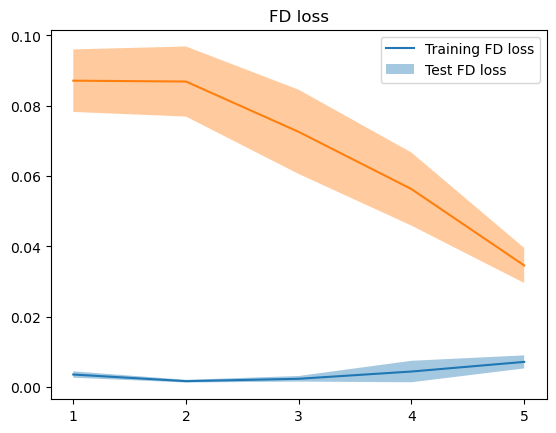

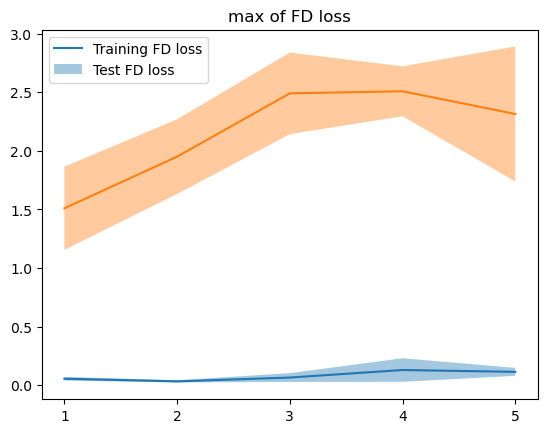

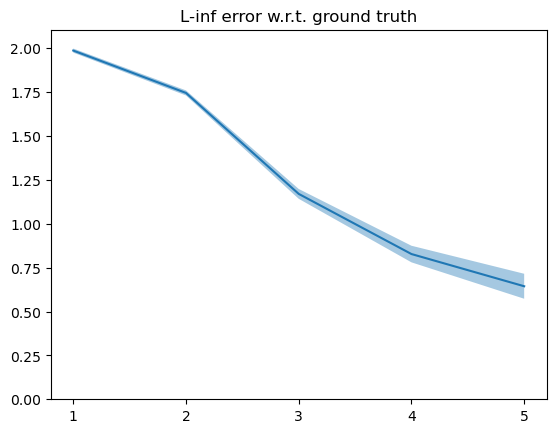

In [5]:
plt.plot(np.arange(rounds) , training_error_history2.mean(0))
plt.fill_between(np.arange(rounds) , 
                 training_error_history2.mean(0) - training_error_history2.std(0), 
                training_error_history2.mean(0) + training_error_history2.std(0), alpha=0.4)

plt.plot(np.arange(rounds) , test_error_history2.mean(0))
plt.fill_between(np.arange(rounds), 
                test_error_history2.mean(0) - test_error_history2.std(0),
                test_error_history2.mean(0) + test_error_history2.std(0), alpha = 0.4)

plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('FD loss')
plt.show()

plt.plot(np.arange(rounds) , training_error_history2_max.mean(0))
plt.fill_between(np.arange(rounds),
                 training_error_history2_max.mean(0) - training_error_history2_max.std(0),
                training_error_history2_max.mean(0) + training_error_history2_max.std(0),
                alpha = .4)

plt.plot(np.arange(rounds) , test_error_history2_max.mean(0))
plt.fill_between(np.arange(rounds),
                test_error_history2_max.mean(0) - test_error_history2_max.std(0),
                test_error_history2_max.mean(0) + test_error_history2_max.std(0),
                alpha = .4)
#plt.ylim(0, test_error_history1_max.max().item()+.1)
plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('max of FD loss')
plt.show()

plt.plot(np.arange(rounds), L_inf_error_history2.mean(0))
plt.fill_between(np.arange(rounds),
                L_inf_error_history2.mean(0) - L_inf_error_history2.std(0),
                L_inf_error_history2.mean(0) + L_inf_error_history2.std(0),
                alpha = .4)

plt.ylim(0, L_inf_error_history2.max().item()+0.1)
plt.title('L-inf error w.r.t. ground truth')
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.show()

# Re-sampling

In [6]:
MSE_history3 = torch.zeros([n_experiments, rounds])
L_inf_error_history3 = torch.zeros([n_experiments, rounds]) 

training_error_history3 = torch.zeros([n_experiments, rounds])
test_error_history3 = torch.zeros([n_experiments, rounds])

test_error_history3_max = torch.zeros([n_experiments, rounds])

from Training.training import train

training_params['n_coloc_points'] = 300
training_params['n_boundary_points'] = 50
n_ite = 2500
training_params['num_iterations'] = n_ite

for j in range(n_experiments):
    # We initialise the NN
    NN3 = FCFF_3L([dim,30,30])
    training_params['optimizer'] = optim.SGD(NN3.parameters(), lr = .01, momentum = .2)

    
    for i in range(rounds):
    
        training_params['alpha'] = alpha_list[i]
        training_params['delta'] = delta_list[i]

        total_loss, PDE_loss, boundary_loss = train(NN3, domain, training_params)

        MC_points = int(1e5) # Number of grid points for comparison with the ground truth
        MSE, L_inf = error_ball(NN3, max(radii), MC_points, display = False)
        
        with torch.no_grad():
            #training_error = FD_loss(NN2, training_data_int, training_params)
            test_error = FD_loss(NN3, test_data, training_params)
        
        training_error_history3[j,i] = PDE_loss[-1]
        test_error_history3[j,i] = test_error.mean()
        test_error_history3_max[j,i] = test_error.max().item()
        
        MSE_history3[j,i] = MSE
        L_inf_error_history3[j,i] = L_inf
        
        print('Mean square error:', MSE)
        print('L-infinity error:', L_inf)

100%|██████████| 2500/2500 [00:13<00:00, 181.90it/s]


Mean square error: tensor(0.1152)
L-infinity error: tensor(1.9840)


100%|██████████| 2500/2500 [00:13<00:00, 180.09it/s]


Mean square error: tensor(0.0710)
L-infinity error: tensor(1.7135)


100%|██████████| 2500/2500 [00:13<00:00, 185.41it/s]


Mean square error: tensor(0.0214)
L-infinity error: tensor(1.0636)


100%|██████████| 2500/2500 [00:13<00:00, 181.57it/s]


Mean square error: tensor(0.0099)
L-infinity error: tensor(0.7038)


100%|██████████| 2500/2500 [00:14<00:00, 175.15it/s]


Mean square error: tensor(0.0057)
L-infinity error: tensor(0.4557)


100%|██████████| 2500/2500 [00:13<00:00, 185.75it/s]


Mean square error: tensor(0.1115)
L-infinity error: tensor(1.9755)


100%|██████████| 2500/2500 [00:13<00:00, 183.23it/s]


Mean square error: tensor(0.0719)
L-infinity error: tensor(1.7109)


100%|██████████| 2500/2500 [00:13<00:00, 186.03it/s]


Mean square error: tensor(0.0210)
L-infinity error: tensor(1.0596)


100%|██████████| 2500/2500 [00:14<00:00, 176.80it/s]


Mean square error: tensor(0.0093)
L-infinity error: tensor(0.6948)


100%|██████████| 2500/2500 [00:13<00:00, 181.84it/s]


Mean square error: tensor(0.0046)
L-infinity error: tensor(0.4503)


100%|██████████| 2500/2500 [00:13<00:00, 184.44it/s]


Mean square error: tensor(0.1092)
L-infinity error: tensor(1.9723)


100%|██████████| 2500/2500 [00:13<00:00, 188.44it/s]


Mean square error: tensor(0.0689)
L-infinity error: tensor(1.7113)


100%|██████████| 2500/2500 [00:13<00:00, 180.58it/s]


Mean square error: tensor(0.0183)
L-infinity error: tensor(1.0591)


100%|██████████| 2500/2500 [00:13<00:00, 181.88it/s]


Mean square error: tensor(0.0084)
L-infinity error: tensor(0.6967)


100%|██████████| 2500/2500 [00:13<00:00, 189.87it/s]


Mean square error: tensor(0.0047)
L-infinity error: tensor(0.4529)


100%|██████████| 2500/2500 [00:13<00:00, 181.04it/s]


Mean square error: tensor(0.1136)
L-infinity error: tensor(1.9742)


100%|██████████| 2500/2500 [00:14<00:00, 176.19it/s]


Mean square error: tensor(0.0707)
L-infinity error: tensor(1.7072)


100%|██████████| 2500/2500 [00:14<00:00, 172.03it/s]


Mean square error: tensor(0.0201)
L-infinity error: tensor(1.0572)


100%|██████████| 2500/2500 [00:15<00:00, 162.97it/s]


Mean square error: tensor(0.0099)
L-infinity error: tensor(0.7056)


100%|██████████| 2500/2500 [00:15<00:00, 160.62it/s]


Mean square error: tensor(0.0059)
L-infinity error: tensor(0.4619)


100%|██████████| 2500/2500 [00:13<00:00, 188.21it/s]


Mean square error: tensor(0.1179)
L-infinity error: tensor(1.9856)


100%|██████████| 2500/2500 [00:14<00:00, 172.52it/s]


Mean square error: tensor(0.0736)
L-infinity error: tensor(1.7164)


100%|██████████| 2500/2500 [00:12<00:00, 195.52it/s]


Mean square error: tensor(0.0244)
L-infinity error: tensor(1.0700)


100%|██████████| 2500/2500 [00:13<00:00, 187.47it/s]


Mean square error: tensor(0.0118)
L-infinity error: tensor(0.7114)


100%|██████████| 2500/2500 [00:13<00:00, 181.69it/s]


Mean square error: tensor(0.0065)
L-infinity error: tensor(0.4646)


100%|██████████| 2500/2500 [00:13<00:00, 180.82it/s]


Mean square error: tensor(0.1129)
L-infinity error: tensor(1.9731)


100%|██████████| 2500/2500 [00:14<00:00, 172.07it/s]


Mean square error: tensor(0.0701)
L-infinity error: tensor(1.7088)


100%|██████████| 2500/2500 [00:13<00:00, 181.82it/s]


Mean square error: tensor(0.0208)
L-infinity error: tensor(1.0647)


100%|██████████| 2500/2500 [00:13<00:00, 181.53it/s]


Mean square error: tensor(0.0087)
L-infinity error: tensor(0.6981)


100%|██████████| 2500/2500 [00:14<00:00, 177.96it/s]


Mean square error: tensor(0.0061)
L-infinity error: tensor(0.4708)


100%|██████████| 2500/2500 [00:13<00:00, 186.42it/s]


Mean square error: tensor(0.1139)
L-infinity error: tensor(1.9717)


100%|██████████| 2500/2500 [00:12<00:00, 195.26it/s]


Mean square error: tensor(0.0707)
L-infinity error: tensor(1.7030)


100%|██████████| 2500/2500 [00:19<00:00, 128.26it/s]


Mean square error: tensor(0.0189)
L-infinity error: tensor(1.0549)


100%|██████████| 2500/2500 [00:24<00:00, 101.20it/s]


Mean square error: tensor(0.0078)
L-infinity error: tensor(0.6874)


100%|██████████| 2500/2500 [00:24<00:00, 104.04it/s]


Mean square error: tensor(0.0044)
L-infinity error: tensor(0.4506)


100%|██████████| 2500/2500 [00:23<00:00, 105.33it/s]


Mean square error: tensor(0.1147)
L-infinity error: tensor(1.9776)


100%|██████████| 2500/2500 [00:24<00:00, 102.11it/s]


Mean square error: tensor(0.0695)
L-infinity error: tensor(1.7123)


100%|██████████| 2500/2500 [00:24<00:00, 100.33it/s]


Mean square error: tensor(0.0190)
L-infinity error: tensor(1.0565)


100%|██████████| 2500/2500 [00:25<00:00, 99.62it/s] 


Mean square error: tensor(0.0086)
L-infinity error: tensor(0.6927)


100%|██████████| 2500/2500 [00:26<00:00, 94.00it/s] 


Mean square error: tensor(0.0045)
L-infinity error: tensor(0.4518)


100%|██████████| 2500/2500 [00:28<00:00, 88.53it/s] 


Mean square error: tensor(0.1153)
L-infinity error: tensor(1.9827)


100%|██████████| 2500/2500 [00:27<00:00, 90.91it/s] 


Mean square error: tensor(0.0710)
L-infinity error: tensor(1.7134)


100%|██████████| 2500/2500 [00:24<00:00, 103.35it/s]


Mean square error: tensor(0.0231)
L-infinity error: tensor(1.0699)


100%|██████████| 2500/2500 [00:25<00:00, 97.09it/s] 


Mean square error: tensor(0.0103)
L-infinity error: tensor(0.7040)


100%|██████████| 2500/2500 [00:23<00:00, 104.84it/s]


Mean square error: tensor(0.0069)
L-infinity error: tensor(0.4626)


100%|██████████| 2500/2500 [00:25<00:00, 98.84it/s] 


Mean square error: tensor(0.1121)
L-infinity error: tensor(1.9759)


100%|██████████| 2500/2500 [00:23<00:00, 107.93it/s]


Mean square error: tensor(0.0687)
L-infinity error: tensor(1.7047)


100%|██████████| 2500/2500 [00:23<00:00, 105.64it/s]


Mean square error: tensor(0.0202)
L-infinity error: tensor(1.0581)


100%|██████████| 2500/2500 [00:22<00:00, 111.37it/s]


Mean square error: tensor(0.0089)
L-infinity error: tensor(0.6996)


100%|██████████| 2500/2500 [00:24<00:00, 103.38it/s]


Mean square error: tensor(0.0054)
L-infinity error: tensor(0.4576)


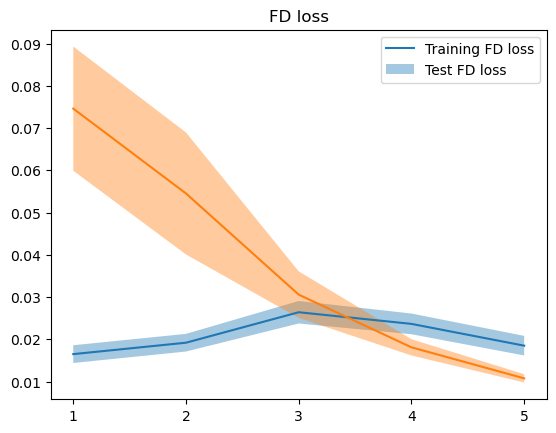

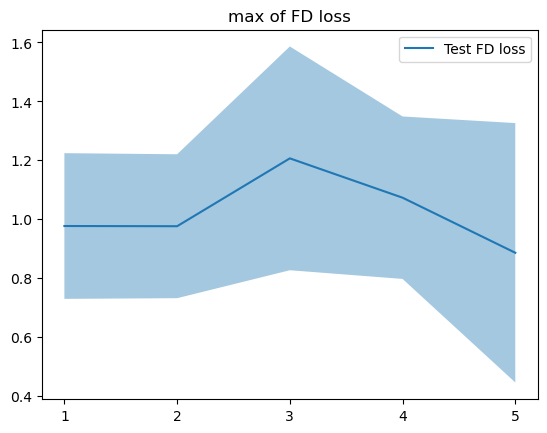

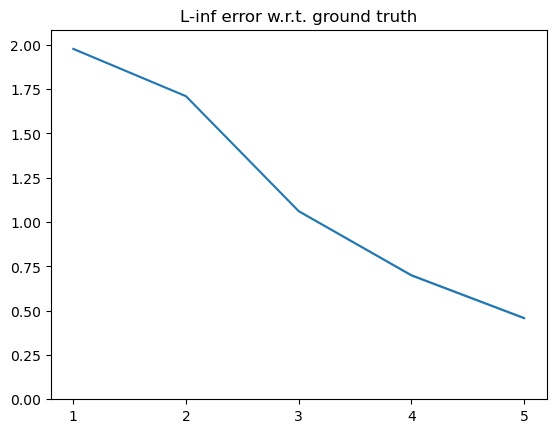

In [7]:
plt.plot(np.arange(rounds) , training_error_history3.mean(0))
plt.fill_between(np.arange(rounds) , 
                 training_error_history3.mean(0) - training_error_history3.std(0), 
                training_error_history3.mean(0) + training_error_history3.std(0), alpha=0.4)

plt.plot(np.arange(rounds) , test_error_history3.mean(0))
plt.fill_between(np.arange(rounds), 
                test_error_history3.mean(0) - test_error_history3.std(0),
                test_error_history3.mean(0) + test_error_history3.std(0), alpha = 0.4)

plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('FD loss')
plt.show()

plt.plot(np.arange(rounds) , test_error_history3_max.mean(0))
plt.fill_between(np.arange(rounds),
                test_error_history3_max.mean(0) - test_error_history3_max.std(0),
                test_error_history3_max.mean(0) + test_error_history3_max.std(0),
                alpha = .4)
plt.legend(labels = ['Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('max of FD loss')
plt.show()

plt.plot(np.arange(rounds), L_inf_error_history3.mean(0))
plt.fill_between(np.arange(rounds),
                L_inf_error_history3.mean(0) - L_inf_error_history3.std(0),
                L_inf_error_history3.mean(0) + L_inf_error_history3.std(0),
                alpha = .4)

plt.ylim(0, L_inf_error_history3.max().item()+0.1)
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('L-inf error w.r.t. ground truth')
plt.show()

<>:78: SyntaxWarning: invalid escape sequence '\l'
<>:105: SyntaxWarning: invalid escape sequence '\l'
<>:78: SyntaxWarning: invalid escape sequence '\l'
<>:105: SyntaxWarning: invalid escape sequence '\l'
C:\Users\usuario\AppData\Local\Temp\ipykernel_24892\1440510797.py:78: SyntaxWarning: invalid escape sequence '\l'
  plt.title('$\log_{10} (MSE)$', fontsize = 'xx-large')
C:\Users\usuario\AppData\Local\Temp\ipykernel_24892\1440510797.py:105: SyntaxWarning: invalid escape sequence '\l'
  plt.title('$\log_{10} (E_{\infty})$', fontsize = 'xx-large')


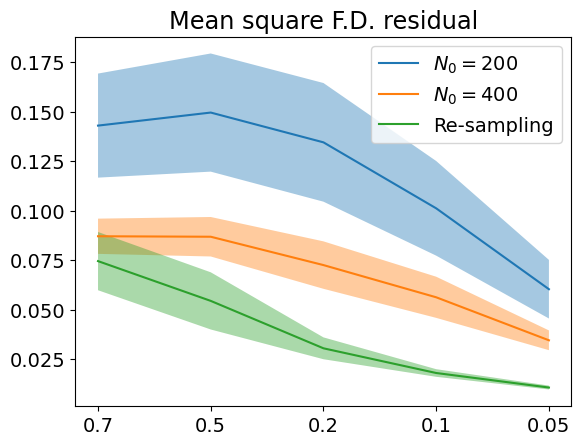

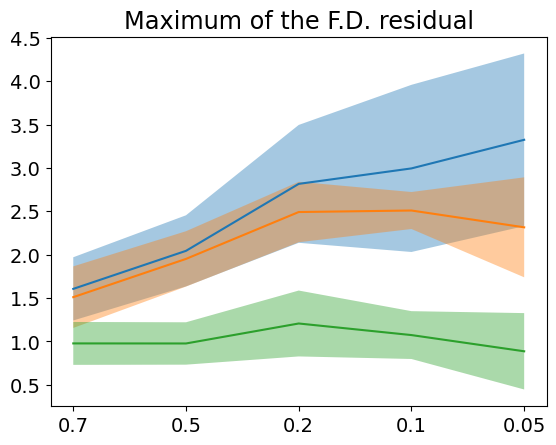

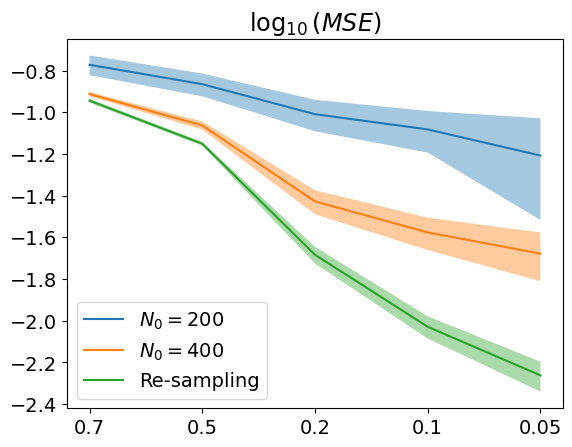

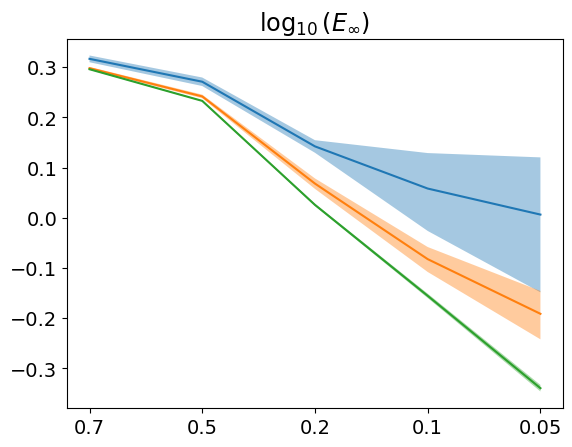

In [8]:
plt.plot(np.arange(rounds) , test_error_history1.mean(0))
plt.plot(np.arange(rounds) , test_error_history2.mean(0))
plt.plot(np.arange(rounds) , test_error_history3.mean(0))

plt.fill_between(np.arange(rounds), 
                test_error_history1.mean(0) - test_error_history1.std(0),
                test_error_history1.mean(0) + test_error_history1.std(0), alpha = 0.4)

plt.fill_between(np.arange(rounds), 
                test_error_history2.mean(0) - test_error_history2.std(0),
                test_error_history2.mean(0) + test_error_history2.std(0), alpha = 0.4)

plt.fill_between(np.arange(rounds), 
                test_error_history3.mean(0) - test_error_history3.std(0),
                test_error_history3.mean(0) + test_error_history3.std(0), alpha = 0.4)

plt.legend(labels = ['$N_0 = 200$', '$N_0 = 400$', 'Re-sampling'], fontsize=14)
plt.xticks([i for i in range(rounds)], [ delta_list[i] for i in range(rounds)])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Mean square F.D. residual', fontsize = 'xx-large')
plt.show()


plt.plot(np.arange(rounds) , test_error_history1_max.mean(0))
plt.plot(np.arange(rounds) , test_error_history2_max.mean(0))
plt.plot(np.arange(rounds) , test_error_history3_max.mean(0))

plt.fill_between(np.arange(rounds),
                test_error_history1_max.mean(0) - test_error_history1_max.std(0),
                test_error_history1_max.mean(0) + test_error_history1_max.std(0),
                alpha = .4)

plt.fill_between(np.arange(rounds),
                test_error_history2_max.mean(0) - test_error_history2_max.std(0),
                test_error_history2_max.mean(0) + test_error_history2_max.std(0),
                alpha = .4)

plt.fill_between(np.arange(rounds),
                test_error_history3_max.mean(0) - test_error_history3_max.std(0),
                test_error_history3_max.mean(0) + test_error_history3_max.std(0),
                alpha = .4)

#plt.legend(labels = ['$N_0 = 80$', '$N_0 = 160$', 'Re-sampling'], fontsize=14)
plt.xticks([i for i in range(rounds)], [ delta_list[i] for i in range(rounds)])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Maximum of the F.D. residual', fontsize = 'xx-large')
plt.show()


plt.plot(np.arange(rounds), MSE_history1.mean(0).log10())
plt.plot(np.arange(rounds), MSE_history2.mean(0).log10())
plt.plot(np.arange(rounds), MSE_history3.mean(0).log10())

plt.fill_between(np.arange(rounds),
                (MSE_history1.mean(0) - MSE_history1.std(0)).log10(),
                (MSE_history1.mean(0) + MSE_history1.std(0)).log10(),
                alpha = .4)

plt.fill_between(np.arange(rounds),
                (MSE_history2.mean(0) - MSE_history2.std(0)).log10(),
                (MSE_history2.mean(0) + MSE_history2.std(0)).log10(),
                alpha = .4)

plt.fill_between(np.arange(rounds),
                (MSE_history3.mean(0) - MSE_history3.std(0)).log10(),
                (MSE_history3.mean(0) + MSE_history3.std(0)).log10(),
                alpha = .4)

plt.legend(labels = ['$N_0 = 200$', '$N_0 = 400$', 'Re-sampling'], fontsize=14)
plt.xticks([i for i in range(rounds)], [ delta_list[i] for i in range(rounds)])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('$\log_{10} (MSE)$', fontsize = 'xx-large')
plt.show()


plt.plot(np.arange(rounds), L_inf_error_history1.mean(0).log10())
plt.fill_between(np.arange(rounds),
                (L_inf_error_history1.mean(0) - L_inf_error_history1.std(0)).log10(),
                (L_inf_error_history1.mean(0) + L_inf_error_history1.std(0)).log10(),
                alpha = .4)

plt.plot(np.arange(rounds), L_inf_error_history2.mean(0).log10())
plt.fill_between(np.arange(rounds),
                (L_inf_error_history2.mean(0) - L_inf_error_history2.std(0)).log10(),
                (L_inf_error_history2.mean(0) + L_inf_error_history2.std(0)).log10(),
                alpha = .4)

plt.plot(np.arange(rounds), L_inf_error_history3.mean(0).log10())
plt.fill_between(np.arange(rounds),
                (L_inf_error_history3.mean(0) - L_inf_error_history3.std(0)).log10(),
                (L_inf_error_history3.mean(0) + L_inf_error_history3.std(0)).log10(),
                alpha = .4)

#plt.legend(labels = ['$N_0 = 80$', '$N_0 = 160$', 'Re-sampling'], fontsize=14)
plt.xticks([i for i in range(rounds)], [ delta_list[i] for i in range(rounds)])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('$\log_{10} (E_{\infty})$', fontsize = 'xx-large')
plt.show()